In [1]:
import os
from functools import partial
from typing import (
  Tuple, List, Dict, Any, Sequence, Callable)

import haiku as hk
import jax
import jax.numpy as jnp
import jax.random as jr 
import jraph
import optax
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from mnist_to_graphs import pad_graph_to_value

need to speed up graph batching
* pre-pad nodes to `PAD_VALUE` and batch them? 
* dataload graphs into batches, then vmap select random nodes of each graph

#### globals

In [2]:
Array = jnp.ndarray
Graph = jraph.GraphsTuple

N_GRAPHS = 6000
LR = 2.e-4
BATCH_SIZE = 16
N_STEPS = 5_000
EVAL_FREQ = 20
PAD_VALUE = 4096 #8128 
F = 64
E = 8

multi_sized = True

#### utils

In [3]:
def print_graph_attributes(g):
    attrs = ["nodes", "edges", "senders", "receivers", "globals", "n_node", "n_edge"]

    for a in attrs:
        val = getattr(g, a)
        print(a, val.shape if val is not None else None)

def adjacency_matrix(sender_indices, receiver_indices, n_nodes=None):
    # Determine the number of nodes in the graph if not provided
    if n_nodes is None:
        n_nodes = max(max(sender_indices), max(receiver_indices)) + 1

    # Create an empty adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))

    # Set entries in the adjacency matrix for each edge
    for sender, receiver in zip(sender_indices, receiver_indices):
        adj_matrix[sender, receiver] = 1 
        adj_matrix[receiver, sender] = 1 

    return adj_matrix

def get_dataloaders(
    simulations, 
    parameters, 
    rng, 
    batch_size=BATCH_SIZE, 
    split=0.1, 
    repeat=True):
    n_train = int((1. - split) * len(simulations))
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (simulations[:n_train], parameters[:n_train]))
    valid_dataset = tf.data.Dataset.from_tensor_slices(
        (simulations[n_train:], parameters[n_train:]))
    if repeat:
        train_dataset = train_dataset.repeat()
        valid_dataset = valid_dataset.repeat()
    train_dataset = train_dataset.shuffle(n_train, seed=int(rng.sum())).batch(batch_size=batch_size)
    train_dataset = train_dataset.as_numpy_iterator()
    valid_dataset = valid_dataset.batch(batch_size=batch_size)
    valid_dataset = valid_dataset.as_numpy_iterator()
    return train_dataset, valid_dataset

#### data

In [4]:
def get_R_z_string(R_values, z_values, n_moments_calculate=3):
    if isinstance(R_values, list):
        if len(R_values) == len(all_R_values):
            R_string = "all"
        else:
            R_string = "_".join([str(float(R)) for R in R_values])
    else:
        R_string = str(R_values)
    if isinstance(z_values, list):
        if len(z_values) == len(all_redshifts):
            z_string = "all"
        else:
            z_string = "_".join([str(float(z)) for z in z_values])
    else:
        z_string = str(z_values)

    return f"x={resolution}_R={R_string}_z={z_string}_nm={n_moments_calculate}"

prng_seq = hk.PRNGSequence(0)

data_dir = "/Users/Jed.Homer/phd/lfi/jaxdelfi/data/"
resolution = 1024 
all_redshifts = [0., 0.5, 1., 2., 3.]
all_R_values = ["5.0", "10.0", "15.0", "20.0", "25.0", "30.0"]

redshifts = all_redshifts[:1]
R_values = all_R_values[:4]

R_idx = [all_R_values.index(R) for R in R_values]
z_idx = [redshifts.index(z) for z in redshifts]

print(f"Running for redshifts:\n{redshifts}\nat resolution x={resolution} with R values:\n{R_values}.")

Rz_string = get_R_z_string(R_values, redshifts, n_moments_calculate=3)

Running for redshifts:
[0.0]
at resolution x=1024 with R values:
['5.0', '10.0', '15.0', '20.0'].


In [5]:
# (z, n, d, R)
all_pdfs = np.load(
    "/Users/Jed.Homer/phd/lfi/jaxdelfi_pdf/data/ALL_PDFS_1024_egg.npy") # downloaded again
all_pdfs_parameters = np.load(
    os.path.join(data_dir, "ALL_PDFS_PARAMS.npy"))

print(all_pdfs.shape)

all_pdfs_z = jnp.stack([all_pdfs[z] for z in z_idx])
all_pdfs_z_R = jnp.stack([all_pdfs_z[..., R] for R in R_idx], axis=-1)
all_pdfs_z_R = all_pdfs_z_R.reshape(2000, 3, -1)
# all_pdfs_z_R = np.moveaxis(all_pdfs_z_R, 1, 0)

all_pdfs_z_R.shape

(5, 2000, 99, 7)


(2000, 3, 132)

#### data
* for each moments datavector, make fully connected subgraph for each redshift, then concatenate all the redshift graphs together...

In [6]:
alpha = jnp.array([0.3175, 0.049, 0.6711, 0.9624, 0.834])
parameters = jnp.load(
        os.path.join(data_dir, f"ALL_PDFS_PARAMS.npy")) 
simulations = jnp.load(
    os.path.join(data_dir, f"CALCULATED_PDF_MOMENTS_{Rz_string}.npy"))
fiducial_dv = jnp.load(
    os.path.join(data_dir, f'fiducial_moments_unflat_{Rz_string}.npy')).mean(axis=0)

n_sims, parameter_dim = parameters.shape
n_z, n_R, n_m = fiducial_dv.shape
data_dim = np.prod(fiducial_dv.shape)

n_multiples = N_GRAPHS // len(parameters)
parameters = jnp.tile(parameters, (n_multiples, 1))
simulations = jnp.tile(simulations, (n_multiples, 1, 1, 1))

parameters.shape, simulations.shape, fiducial_dv.shape

((6000, 5), (6000, 1, 4, 3), (1, 4, 3))

In [7]:
# simulations = all_pdfs_z_R
data_dim = np.prod(simulations.shape[1:])

#### graph builders

In [8]:
def make_subgraphs(moments, n_idx=None, deselect_rng=None):
    """ 
        Pass in as many integers as moments for each R, z moment vector 
    """
    # Vmapping, so this is z-axis
    all_g_z = []
    for i, (z, mz) in enumerate(zip(redshifts, moments)):
        # Give every node (a moment) R and z information
        n_R, n_m = mz.shape
        Rs = jnp.array([float(R) for R in R_values] * n_m)
        zs = jnp.array([z] * n_R * n_m)
        # print(mz.shape, np.prod(mz.shape))
        # print([_.shape for _ in [mz.flatten(), Rs, zs]])

        # Randomly de-select nodes  
        node_datas = [mz.flatten(), Rs, zs]
        # print([_.shape for _ in node_datas])
        #node_features = jnp.stack(node_datas, axis=1)
        # Concatenate for vmapping ...
        node_features = jnp.stack(node_datas, axis=1)
        if deselect_rng is not None and n_idx is not None:
            rng_n, rng_i = jr.split(deselect_rng)
            # Random number of nodes to deselect
            # n_idx = jr.randint(
            #     rng_n, (1,), 0, np.prod(fiducial_dv.shape) - 1)
            # A random number of nodes chosen
            p = jax.nn.softmax(jnp.exp(-jnp.arange(len(node_features))))
            node_idx = jnp.arange(len(node_features))
            idx = jr.choice(
                rng_i, node_idx, (n_idx[i],), p=None, replace=False)
            
            node_features_ = node_features[idx]
            n_node_per_graph = len(node_features_)
        else:
            node_features_ = node_features
            n_node_per_graph = np.prod(mz.shape)
        # print(n_node_per_graph, node_features.shape)

        g_z = jraph.get_fully_connected_graph(
            node_features=node_features_,
            n_node_per_graph=n_node_per_graph,
            n_graph=1,
            global_features=None,
            #global_features=parameters, # maybe just parameters for main_graph not subgraphs?
            add_self_edges=True)
        all_g_z.append(g_z)
    return all_g_z 

def make_graph_from_subgraphs(subgraphs, parameters=None):
    """ 
        Make ONE graph from fully connected redshift-subgraphs
        - NO connections between subgraphs of different redshift
        - for vmapping, may need to remove all "axis adding"...
            -> globals for one graph created as (1, 2) due to added axis 
               so instead make (2,) so they are vmap-stacked ast (B, 2) not (B, 1, 2)
    """
    n_node = sum([g_z.n_node for g_z in subgraphs])
    n_edge = sum([g_z.n_edge for g_z in subgraphs])
    # Note: n_edge is redundant for one redshift + fully connected
    cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32)
    cardinality = cardinality.reshape(1, 2)
    return jraph.GraphsTuple(
        nodes=jnp.concatenate([
            g_z.nodes for g_z in subgraphs]),
        edges=None, 
        # Since graph is made of subgraphs, need to re-index S and R for main_graph indexing...
        senders=jnp.concatenate([
            g_z.n_node * n + g_z.senders 
            for n, g_z in enumerate(subgraphs)]),
        receivers=jnp.concatenate([
            g_z.n_node * n + g_z.receivers 
            for n, g_z in enumerate(subgraphs)]),
        n_node=n_node,
        n_edge=n_edge,
        globals=cardinality)

In [9]:
def make_graph_from_data(moments, n_idx=None, deselect_rng=None):
    """ 
        Pass in as many integers as moments for each R, z moment vector 
    """ 
    n_z, n_R, n_m = moments.shape

    # Get fully connected s,r for each subgraph
    n_node_per_graph = np.prod(moments.shape[1:])
    senders, receivers = jnp.meshgrid(
        jnp.arange(n_node_per_graph), 
        jnp.arange(n_node_per_graph))
    # Flatten the senders and receivers.
    senders = senders.flatten()
    receivers = receivers.flatten()
    n_edge = len(senders) # Fully connected

    # Scale and redshift node info matched to flattened moments
    Rs = jnp.array([float(R) for R in R_values] * n_m)
    zs = jnp.array([[z] * n_R * n_m for z in redshifts]).flatten()
    print("R, z", Rs.shape, zs.shape)

    n_node = n_z * n_node_per_graph
    n_edge = n_z * n_edge
    senders = jnp.array([s + n_node_per_graph for s in senders])
    receivers = jnp.array([r + n_node_per_graph for r in receivers])
    print("s/r", senders.shape, receivers.shape)
    # Note: n_edge is redundant for one redshift + fully connected
    cardinality = jnp.array([n_node, n_edge]).astype(jnp.float32)
    return jraph.GraphsTuple(
        nodes=jnp.stack([moments.flatten(), Rs, zs], axis=1),
        edges=None, 
        senders=senders,
        receivers=receivers,
        n_node=n_node,
        n_edge=n_edge,
        globals=cardinality)

In [10]:
# print(d.shape)
# e = jax.vmap(make_graph_from_data)(d)
# print_graph_attributes(e)

In [11]:
rng = jr.PRNGKey(0)

train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng=rng)

x, y = next(train_dataset)
print(x.shape, y.shape)

# Test vmapping a subgraph creation
g = jax.vmap(make_subgraphs)(x)
print("\n")
# Creates a graph tuple with all the graphs in
print_graph_attributes(g[0])

(16, 1, 4, 3) (16, 5)


nodes (16, 12, 3)
edges None
senders (16, 144)
receivers (16, 144)
globals None
n_node (16, 1)
n_edge (16, 1)


/Users/Jed.Homer/miniconda3/envs/jraph/lib/python3.10/site-packages/jraph/_src/utils.py:882: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  num_node_features = jax.tree_leaves(node_features)[0].shape[0]


In [12]:
def make_graph(data, n_idx=None, rng=None):
    # rng, n_idx == None => same sized graphs
    g = make_graph_from_subgraphs(
        make_subgraphs(data, n_idx, rng))
    return g

g = jax.vmap(make_graph)(x)

print_graph_attributes(g)
print(g.n_node)

nodes (16, 12, 3)
edges None
senders (16, 144)
receivers (16, 144)
globals (16, 1, 2)
n_node (16, 1)
n_edge (16, 1)
[[12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]
 [12]]


In [13]:
# now try deselecting node features in main_graph of subgraphs

def remove_random_nodes(graph, rng, ):
    rng_i, rng_n = jr.split(rng)
    n_nodes = jr.randint(rng_n, )
    # g = g.
    return 

#### model

##### resnet

In [14]:
layernorm_kwargs = dict(axis=1, create_scale=True, create_offset=True)

class LinearResNet(hk.Module):
  def __init__(
    self, 
    hidden_sizes: Sequence[int],
    activation: Callable = jax.nn.leaky_relu,
    activate_final: bool = False):
    super().__init__()
    self.hidden_sizes = hidden_sizes
    self.activation = activation
    self.activate_final = activate_final

  def __call__(self, x):
    # assert x.shape[-1] == self.hidden_size, (
    #   "Input must be hidden size.")
    z = x
    for f in self.hidden_sizes:
      h = self.activation(z)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f)(h)
      h = self.activation(h)
      h = hk.LayerNorm(**layernorm_kwargs)(h)
      h = hk.Linear(f, w_init=jnp.zeros)(h)
      z = z + h 
    return self.activation(z) if self.activate_final else z

##### gnn

In [15]:
@jraph.concatenated_args
def edge_update_fn(feats: Array) -> Array:
  """ Edge update function for graph net. """
  net = hk.Sequential([
    # hk.Linear(F), 
    LinearResNet([F, F, F])])
    # hk.Linear(F), hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args 
def node_update_fn(feats: Array) -> Array:
  """ Node update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F])])
    # hk.Linear(F), 
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: Array) -> Array:
  """ Global update function for graph net. """
  net = hk.Sequential([
    hk.Linear(F), LinearResNet([F, F, F], activate_final=True),
    # hk.nets.MLP([F, F, F], activation=jax.nn.tanh, activate_final=True),
    hk.Linear(parameter_dim, with_bias=True)]) # output summary of parameter dim
  return net(feats)

def LayerNormLinear(x):
    h = hk.LayerNorm(**layernorm_kwargs)(x)
    return hk.Linear(E, with_bias=False)(h)

def net_fn(graph: Graph) -> Graph:
  """ 
    Default aggregator functions for edges, global edges, global nodes 
    are "segment_sum"
  """
  embedder = jraph.GraphMapFeatures(
    embed_node_fn=LayerNormLinear, 
    embed_global_fn=LayerNormLinear) 
  graph = embedder(graph)
  for _ in range(4):
    net = jraph.GraphNetwork(
        update_edge_fn=None,
        update_node_fn=node_update_fn,
        update_global_fn=update_global_fn)
    graph = net(graph)
  return graph

#### train

In [16]:
train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng)

d, y = next(train_dataset)

print("data", d.shape, "\n")

g = make_graph(d[0])
G = jax.vmap(make_graph)(d)
%timeit jax.vmap(make_graph)(d)

print_graph_attributes(g)
print("\n")
print_graph_attributes(G)

print("\n")

gs = [make_graph(d_) for d_ in d]
%timeit jraph.batch(gs)
gs = jraph.batch(gs)
print_graph_attributes(gs)

data (16, 1, 4, 3) 

2.35 ms ± 98.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
nodes (12, 3)
edges None
senders (144,)
receivers (144,)
globals (1, 2)
n_node (1,)
n_edge (1,)


nodes (16, 12, 3)
edges None
senders (16, 144)
receivers (16, 144)
globals (16, 1, 2)
n_node (16, 1)
n_edge (16, 1)


2.88 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
nodes (192, 3)
edges None
senders (2304,)
receivers (2304,)
globals (16, 2)
n_node (16,)
n_edge (16,)


#### trainer functions

In [17]:
def compute_loss(
  params: hk.Params, 
  graph: Graph, 
  label: Array,
  net: Graph) -> Tuple[Array, Array]:
  pred_graph = net.apply(params, graph)
  preds = pred_graph.globals
  mask = jraph.get_graph_padding_mask(pred_graph)
  loss = (jnp.square(jnp.subtract(preds, label)) * mask[:, None]).mean()
  return loss, (None,)
 
@jax.jit
def get_graph_(d):
    # return jraph.batch([
    #   pad_graph_to_value(make_graph(d_), PAD_VALUE) for d_ in d])
    # return pad_graph_to_value(
    #   jraph.batch([
    #     make_graph(d_) for d_ in d]), PAD_VALUE)
    return jraph.batch([
        make_graph(d_) for d_ in d])

def train(
  simulations: Array, 
  parameters: Array, 
  num_train_steps: int) -> Tuple[hk.Params, List]:
  """
    Pad only edges/nodes/senders/receivers.
    - these change size with number of nodes in graph
    - global attr constant shape for any graph with whatever n_nodes
  """

  rng = jr.PRNGKey(0)

  train_dataset, valid_dataset = get_dataloaders(
    simulations, parameters, rng, batch_size=BATCH_SIZE)

  net = hk.without_apply_rng(hk.transform(net_fn))
    
  d, y = next(train_dataset)
  # graph = get_graph(d)


#   get_graph_ = jax.vmap(get_graph_)
#   get_graph_ = jax.vmap(make_graph)

  # graph = jraph.batch([make_graph(d_) for d_ in d])
  graph = get_graph_(d)
  print_graph_attributes(graph)
#   graph = pad_graph_to_value(graph, PAD_VALUE)
#   print_graph_attributes(graph)
  params = net.init(rng, graph)

  print(f"n_params = {sum(x.size for x in jax.tree_util.tree_leaves(params)):.2E}")

  # Initialize the optimizer.
  opt_init, opt_update = optax.adabelief(LR)
  opt_state = opt_init(params)

  compute_loss_fn = partial(compute_loss, net=net)
  eval_fn = jax.jit(compute_loss_fn)
  compute_loss_fn = jax.jit(
    jax.value_and_grad(compute_loss_fn, has_aux=True))

  train_losses, valid_losses = [], []
  for s in range(num_train_steps):

    # Train
    d, y = next(train_dataset)
    graph = get_graph_(d)
    # graph = pad_graph_to_value(graph, PAD_VALUE)
    # y = jnp.concatenate([y, jnp.zeros((1, parameter_dim))])

    (train_loss, (_)), grad = compute_loss_fn(params, graph, y)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)

    # Validate
    d, y = next(valid_dataset)
    graph = get_graph_(d)
    # graph = pad_graph_to_value(graph, PAD_VALUE)
    # y = jnp.concatenate([y, jnp.zeros((1, parameter_dim))])
    valid_loss, _ = eval_fn(params, graph, y)

    if s % EVAL_FREQ == 0:
      print(f'\rstep: {s:06d}, L_t: {train_loss:.4f} L_v: {valid_loss:.4f}', end="")
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

  return params, np.asarray([train_losses, valid_losses])

#### train

In [18]:
params, losses = train(simulations, parameters, num_train_steps=N_STEPS)

nodes (192, 3)
edges None
senders (2304,)
receivers (2304,)
globals (16, 2)
n_node (16,)
n_edge (16,)
n_params = 2.40E+05
step: 004980, L_t: 0.0085 L_v: 0.0042306

250
250


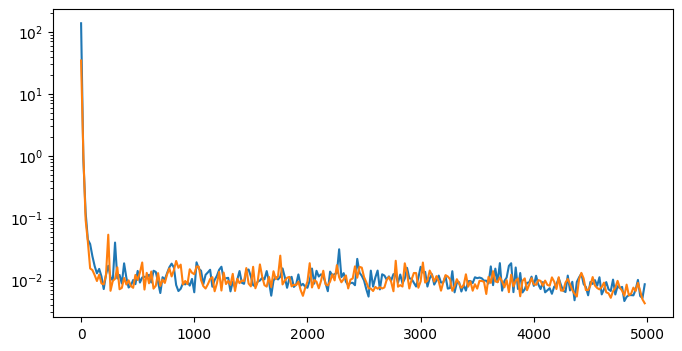

In [19]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8.,4.))
L_t, L_v = losses
steps = range(0, N_STEPS, EVAL_FREQ)
ax.semilogy(steps, L_t)
ax.semilogy(steps, L_v)
plt.show()

In [20]:
# graphs = []
# for gl in dataset_processed:
#     g, l = gl.values()
#     graphs.append(g)

# all_graphs = jraph.batch(graphs)

# print_graph_attributes(all_graphs)



NameError: name 'dataset_processed' is not defined

In [ ]:
fiducial_subgraphs = make_subgraphs(fiducial_dv)
fiducial_graph = make_graph_from_subgraphs(fiducial_subgraphs, alpha[None, :])

[(12,), (12,), (12,)]
12 (12, 3)


In [ ]:
all_graphs_out = net.apply(params, all_graphs)
fiducial_graph_out = net.apply(params, fiducial_graph)

preds = all_graphs_out.globals
fiducial_preds = fiducial_graph_out.globals

fiducial_preds.shape 

(1, 5)

In [ ]:
# List of graphs
if None:
    unbatched_graphs = jraph.unbatch(all_graphs_out)
    isinstance(unbatched_graphs, list)

    A = adjacency_matrix(unbatched_graphs[0].senders, unbatched_graphs[0].receivers)
    plt.imshow(A, cmap="gray_r")
    plt.show()

senders and receivers are constant through application of graph interaction network

In [ ]:
if None:
    A = adjacency_matrix(fiducial_graph_out.senders, fiducial_graph_out.receivers)
    plt.imshow(A, cmap="gray_r")
    print(A.mean())
    plt.show()

(6000, 2) (6000, 2)
1.0 11.0


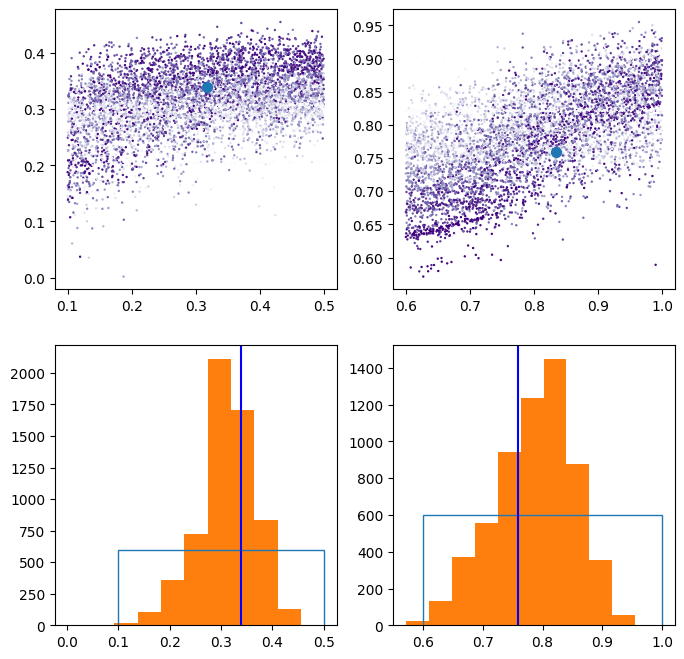

In [ ]:
cmap = "Purples"

target_idx = jnp.array([0, 4])
pred_targets = preds[:, target_idx]
parameter_targets = parameters[:N_GRAPHS, target_idx]

print(pred_targets.shape, parameter_targets.shape)
print(min(all_n_nodes), max(all_n_nodes))

fig, axs = plt.subplots(2, 2, figsize=(8., 8.), dpi=100)
ax = axs[0, 0]

ax.scatter(parameter_targets[:, 0], pred_targets[:, 0], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 0], fiducial_preds[:, 0], s=50.)
ax = axs[0, 1]
ax.scatter(parameter_targets[:, 1], pred_targets[:, 1], c=all_n_nodes, s=0.5, cmap=cmap)
ax.scatter(alpha[None, :][:, 4], fiducial_preds[:, 4], s=50.)
ax = axs[1, 0]
ax.hist(parameter_targets[:, 0], histtype="step")
ax.hist(pred_targets[:, 0])
ax.axvline(fiducial_preds[:, 0], color="blue")
ax = axs[1, 1]
ax.hist(parameter_targets[:, 1], histtype="step")
ax.hist(pred_targets[:, 1])
ax.axvline(fiducial_preds[:, 4], color="blue")
plt.show()

In [ ]:
fiducial_preds.shape

(1, 5)

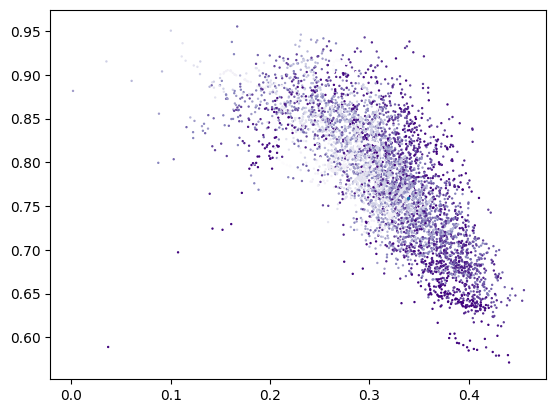

In [ ]:
plt.figure()
plt.scatter(*pred_targets.T, s=0.5, c=all_n_nodes, cmap=cmap)
plt.scatter(*fiducial_preds[:, target_idx].T, s=2.)
plt.show()